In [ ]:
import re
import itertools 
import operator
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from heapq import nlargest 
from heapq import nsmallest


#mount drive
from google.colab import drive
drive.mount('/content/drive')
list_of_receipts = []

#load to pandas to preview
import csv
vis_receipts = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Basket Analysis/data.csv')
vis_receipts.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,2000-01-01,1,yogurt
0,2000-01-01,1,pork
1,2000-01-01,1,sandwich bags
2,2000-01-01,1,lunch meat
3,2000-01-01,1,all- purpose
4,2000-01-01,1,flour


As we can see, the file contains rows of [Date, Receipt #, Item].
Each receipt is currently split between multiple lines. We need to aggregate these into a more usable form. 


In [ ]:
#a fucntion to neatly display our rules (used later)
def print_rules(rules, n):
  i=0
  print("---Top {} rules---".format(n))
  for (a,b),v in rules:
      if i <= n:

        print("{} -> {}: {}%".format(a,b,round(v*100,3)))
        i = i+1


with open('/content/drive/My Drive/Colab Notebooks/Basket Analysis/data.csv') as f:
  reader = csv.reader(f)
  last_i = 1
  receipt_items = []
  for i,line in enumerate(reader):
    #if receipt_index is the same as the last line, append current item to receipt_items
    if int(line[1]) == last_i:
      receipt_items.append(line[2])
    #else, 1. Append the receipt_items to the list_of_receipts & start a new list with new current item
    else:
      list_of_receipts.append(receipt_items)
      receipt_items = []
      receipt_items.append(line[2])
      last_i = last_i + 1

#see how we aggregated
print("Sample of Receipts: {}".format(list_of_receipts[:2]))
print("Number of Receipts: {}".format(len(list_of_receipts)))


Sample of Receipts:  [['yogurt', 'pork', 'sandwich bags', 'lunch meat', 'all- purpose', 'flour', 'soda', 'butter', 'vegetables', 'beef', 'aluminum foil', 'all- purpose', 'dinner rolls', 'shampoo', 'all- purpose', 'mixes', 'soap', 'laundry detergent', 'ice cream', 'dinner rolls'], ['toilet paper', 'shampoo', 'hand soap', 'waffles', 'vegetables', 'cheeses', 'mixes', 'milk', 'sandwich bags', 'laundry detergent', 'dishwashing liquid/detergent', 'waffles', 'individual meals', 'hand soap', 'vegetables', 'individual meals', 'yogurt', 'cereals', 'shampoo', 'vegetables', 'aluminum foil', 'tortillas', 'mixes']]
# of Receipts:  1138


Let's also see how many items are in the normal shopping cart. 

Min Items: 5
Max Items: 34
Average Items: 19.629173989455186


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


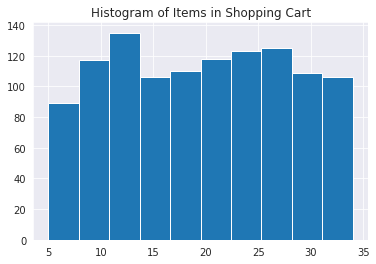

In [ ]:
counts_of_items = []
for r in list_of_receipts:
  counts_of_items.append(len(r))

#print summary statistics
min_items = min(counts_of_items)
max_items = max(counts_of_items)
avg_items = sum(counts_of_items)/ len(counts_of_items)

print("Min Items: {}".format(min_items))
print("Max Items: {}".format(max_items))
print("Average Items: {}".format(avg_items))



sns.set_style('darkgrid')
_ = plt.hist(counts_of_items)  # arguments are passed to np.histogram
plt.title("Histogram of Items in Shopping Cart")

plt.show()

It looks like the carts range from 5-34 items, with the average being nearly 20 items per cart. 

For our basket analysis, we'll need counts of item occurances. 

We'll need a list of the occurances of every item $Freq(A)$ and the number of occurrances of pairs of items$Freq(A,B)$.


In [ ]:
item_counts = defaultdict(int)
pair_counts = defaultdict(int)

#count occurance of each items
def get_item_counts(item_counts, itemset):
    for r in itemset:
      #add 1 to item_count for each item in each receipt
      for item in set(r):
        item_counts[item] += 1

#count occurance of each pair
def get_pair_counts (pair_counts, item_counts, itemset): 
    for r in itemset:
      for combo in itertools.combinations(set(r),2):
        if combo[0] != combo[1]:
          pair_counts[combo] += 1
          
get_item_counts(item_counts, list_of_receipts)
get_pair_counts(pair_counts, item_counts, list_of_receipts)

print("Distinct Items: {}".format(len(item_counts.items())))
print("Disctinct Pairs: {}".format(len(pair_counts.items())))


Distinct Items: 38
Disctinct Pairs: 1123


This is a good point to make some observations on our data. Let's look at what items sell least. We can probably eliminate these from our store if the counts are extremely low. Doing this would help us free up shelf space and reduce inventory with low turnover.  


In [ ]:
#get n higest/lowers items based on frequency
high_sellers = nlargest(3, item_counts, key = item_counts.get) 
low_sellers = nsmallest(3, item_counts, key = item_counts.get) 

print("--Low Sellers--")
for val in low_sellers: 
    print(val, ":", item_counts.get(val)) 

print("\n\n--High Sellers--")
for val in high_sellers: 
    print(val, ":", item_counts.get(val)) 


--Low Sellers--
hand soap : 394
sandwich loaves : 398
flour : 402


--High Sellers--
vegetables : 841
poultry : 480
ice cream : 454


Nothing useful... We still have relatively large sales for even the items that have sold the least. And we can't just not sell hand-soap or sandwich loaves in a grocery store...



---



#**Association Rules**


Lets now calculate the item and pair supports. These meausre how often we expect items (or pairs of items) to appear in random carts. 

$Support(A) = \frac{frequency(A)}{N}$

$Support(A\cup B) = \frac{frequency(A \cup B)}{N}$

In [ ]:
#Item Support
item_support = dict()
for k,v in item_counts.items():
  item_support[k] = v/ len(list_of_receipts)

#Pair Support
pair_support = dict()
for k,v in pair_counts.items():
  pair_support[k] = v/ len(list_of_receipts)


#sort our rules based on support 
sorted_item_support = sorted(item_support.items(), key=lambda kv: kv[1])  
sorted_pair_support = sorted(pair_support.items(), key=lambda kv: kv[1])

#print top 5 rules
print_rules(sorted_pair_support[::-1],5)

---Top 5 rules---
eggs -> vegetables: 32.689%
vegetables -> waffles: 31.371%
vegetables -> ice cream: 30.228%
vegetables -> sugar: 29.701%
vegetables -> milk: 29.613%
vegetables -> spaghetti sauce: 29.525%


As we can see, the average shopper has nearly a 74% chance of purchasing vegetables. We also see there's a 33% chance of purchasing both Eggs and Vegetables. 


# Confidence Rules


Now we'll focus on calculating the confidence rules. Here we want to determine how often item B is purchased when item A is already being purchased. 

$Conf(A \Rightarrow B) = \frac{Support(A \cup B)}{Support(A))}$

In [ ]:
#Generate Confidence Rules

confidence_rules = dict()

for k,v in pair_counts.items():
  #calculate confidence
  confidence = pair_support[k] / item_support[k[0]]
  if confidence < 1:
    confidence_rules[k] = confidence

#sort rules by confidence
sorted_confidence = sorted(confidence_rules.items(), key=lambda kv: kv[1])

#print top 20 rules
print_rules(sorted_confidence[::-1], 20)

---Top 20 rules---
eggs -> vegetables: 83.784%
sandwich loaves -> vegetables: 80.151%
ketchup -> vegetables: 78.487%
dishwashing liquid/detergent -> vegetables: 72.398%
butter -> vegetables: 59.905%
fruits -> vegetables: 59.005%
dinner rolls -> vegetables: 58.465%
cereals -> vegetables: 58.093%
poultry -> vegetables: 57.917%
beef -> vegetables: 57.611%
toilet paper -> vegetables: 56.148%
laundry detergent -> vegetables: 55.116%
lunch meat -> vegetables: 54.889%
soap -> vegetables: 50.694%
eggs -> soda: 47.973%
pasta -> vegetables: 47.518%
coffee/tea -> vegetables: 47.222%
paper towels -> ice cream: 46.973%
lunch meat -> waffles: 46.667%
yogurt -> vegetables: 46.347%
poultry -> dinner rolls: 46.25%


As we saw before, it's common for Eggs and Vegetables to be purchased at the same time. Indeed, if we are purchasing eggs, there's a nealry 84% chance we'll also purchase vegetables. 
